---

**Lesson 7** of the YT course:

[***Machine Learning for Audio Signals in Python - MLfAS***](https://www.youtube.com/playlist?list=PL6QnpHKwdPYjfCH2zkMGEHu2kv1HTICYA)

Original Jupyter Notebooks by [*Renato Profeta*](https://www.youtube.com/c/GuitarsAI)

---

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import os
import librosa

In [18]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device=", device)

device= cpu


#Denoising Autoencoder
###Experiment 1 with stride=512



The goal of the denoising Autoencoder is to reconstruct the clean version of its input. Hence it is trained on noisy signals as trainings set.

In [19]:
def signal2pytorch(x):
    #Function to convert a signal vector x, like a mono audio signal, into a 3-d Tensor that conv1d of Pytorch expects,
    #https://pytorch.org/docs/stable/nn.html
    #Argument x: a 1-d signal as numpy array
    #input x[batch,sample]
    #output: 3-d Tensor X for conv1d input.
    #for conv1d Input: (N,Cin,Lin), Cin: numer of input channels (e.g. for stereo), Lin: length of signal, N: number of Batches (signals) 
    X = np.expand_dims(x, axis=0)  #add channels dimension (here only 1 channel)
    if len(x.shape)==1: #mono:
        X = np.expand_dims(X, axis=0)  #add batch dimension (here only 1 batch)
    X=torch.from_numpy(X)
    X=X.type(torch.Tensor)
    X=X.permute(1,0,2)  #make batch dimension first
    return X

In [20]:
class Convautoenc(nn.Module):
    def __init__(self):
        super(Convautoenc, self).__init__()
        #Analysis Filterbank with downsampling of N=1024, filter length of 2N, but only N/2 outputs:
        self.conv1=nn.Conv1d(in_channels=1, out_channels=32, kernel_size=2048, stride=512, padding=1023, bias=True) #Padding for 'same' filters (kernel_size/2-1)

        #Synthesis filter bank:
        self.synconv1=nn.ConvTranspose1d(in_channels=32, out_channels=1, kernel_size=2048, stride=512, padding=1023, bias=True)

    def encoder(self, x):
        #Analysis:
        x = self.conv1(x)
        y = torch.tanh(x)
        return y
      
    def decoder(self, y):
        #Synthesis:
        xrek= self.synconv1(y)
        return xrek
      
    def forward(self, x):
        y=self.encoder(x)
        #y=torch.round(y/0.125)*0.125
        xrek=self.decoder(y)
        return xrek

In [21]:
batch=1
audio, samplerate = librosa.load("./SR CUSTOM AMEN VARIATION.wav", mono=False, sr=None, offset=6)
audio[0,:]/=np.abs(audio[0,:]).max()
audio[1,:]/=np.abs(audio[1,:]).max()
X_train=signal2pytorch(audio[0,:]).to(device) #Convert to pytorch format, batch is first dimension; we use channel right to train and left to test    
X_test=signal2pytorch(audio[1,:]).to(device) #Convert to pytorch format, batch is first dimension  

In [22]:
print("Generate Model:")
model = Convautoenc().to(device)
print('Total number of parameters: %i' % (sum(p.numel() for p in model.parameters() if p.requires_grad)))
print("Def. loss function:")
loss_fn = nn.MSELoss()  #MSE
#loss_fn = nn.L1Loss()
    
Ypred=model(X_train)
   
#Ypred=Ypred.detach()
outputlen=len(Ypred[0,0,:]) #length of the signal at the output of the network.
print("outputlen=", outputlen)
    
Y=X_train[:,:,:outputlen]  #the target signal with same length as model output
    
print("Input X.shape=", X_train.shape )
print("Target Y.shape=", Y.shape)
print("Target Y=", Y)
#print("max(max(Y))=", max(max(max(Y))))
#print("min(min(Y))=", min(min(min(Y))))
print("Y.type()=", Y.type())

Generate Model:
Total number of parameters: 131105
Def. loss function:
outputlen= 1976322
Input X.shape= torch.Size([1, 1, 1976718])
Target Y.shape= torch.Size([1, 1, 1976322])
Target Y= tensor([[[ 0.0005,  0.0005,  0.0005,  ...,  0.0128, -0.0198,  0.0056]]])
Y.type()= torch.FloatTensor


In [23]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)#, betas=(0.9, 0.999))
"""
try:
    checkpoint = torch.load("audio_autoenc.torch",map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])
    #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
except IOError:
    print("fresh start")
""";
    
#optimrandomdir_pytorch.optimizer(model, loss_fn, X, Ypred, iterations=300, startingscale=1.0, endscale=0.0)
Ypred=model(X_train)
#Ypred=Ypred.detach()
print("Ypred=", Ypred)
    
#randdir=True # True for optimization of random direction, False for pytorch optimization
randdir=False
    
if randdir==True:
#optimization of weights using method of random directions:
    optimrandomdir_pytorch.optimizer(model, loss_fn, X_train, Y, iterations=100000, startingscale=0.25, endscale=0.0)
    #--End optimization of random directions------------------------
else:
    for epoch in range(1000):
        #distortions: shift and noise:

        #-------
        #To make it shift invariant, we can also include a cyclic ("round robin") shift 
        #as another type of distortion in the trainings loop, for the input X and the target Y
        Xlast=X_train[:,:,-1].clone() 
        X_train[:,:,1:]=X_train[:,:,:-1].clone() #round Robbin, shift 1 right
        X_train[:,:,0]=Xlast.clone()
        Ylast=Y[:,:,-1].clone() 
        Y[:,:,1:]=Y[:,:,:-1].clone() #round Robbin, shift 1 right
        Y[:,:,0]=Ylast.clone()
        #-------

        #To avoid that the denoising Autoencoder learns a specific instance of the noise, 
        #a new instance of the noise is generated for each epoch of the training process
        Ypred=model(X_train+torch.randn(X_train.size())*0.05)
        #print("Ypred.shape=", Ypred.shape)
        #loss wants batch in the beginning! (Batch, Classes,...)
        #Ypredp=Ypred.permute(1,2,0)
        #Yp=Y.permute(1,0)
        #print("Ypredp.shape=", Ypredp.shape, "Yp.shape=", Yp.shape )
        loss=loss_fn(Ypred, Y)
        if epoch%10==0:
            print(epoch, loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Ypred= tensor([[[-0.0186, -0.0035,  0.0008,  ..., -0.0027, -0.0079, -0.0060]]],
       grad_fn=<SqueezeBackward1>)
0 0.04843316599726677
10 0.04711354523897171
20 0.04512595012784004
30 0.04237481579184532
40 0.03961561247706413
50 0.03745805844664574
60 0.03599363937973976
70 0.03498576208949089
80 0.03423581272363663
90 0.033595044165849686
100 0.0330384224653244
110 0.0325043611228466
120 0.03201480954885483
130 0.0315280444920063
140 0.031075123697519302
150 0.030600382015109062
160 0.030178673565387726
170 0.0297746229916811
180 0.02943171001970768
190 0.02909970097243786
200 0.028797045350074768
210 0.028502484783530235
220 0.02825178951025009
230 0.028010981157422066
240 0.027807213366031647
250 0.027604829519987106
260 0.02739087864756584
270 0.027221469208598137
280 0.027041496708989143
290 0.026895487681031227
300 0.026706168428063393
310 0.026575833559036255
320 0.026417922228574753
330 0.02627629041671753
340 0.026157395914196968
350 0.026019493117928505
360 0.0258917212486

ww= OrderedDict([('conv1.weight', tensor([[[ 0.0120,  0.0097,  0.0155,  ..., -0.0052, -0.0227,  0.0015]],

        [[-0.0237, -0.0027,  0.0007,  ..., -0.0276, -0.0035,  0.0050]],

        [[-0.0188,  0.0132,  0.0033,  ...,  0.0088,  0.0108, -0.0341]],

        ...,

        [[ 0.0033, -0.0179,  0.0326,  ...,  0.0331,  0.0083,  0.0116]],

        [[-0.0177, -0.0478, -0.0594,  ..., -0.0020, -0.0195, -0.0535]],

        [[-0.0061,  0.0053,  0.0083,  ..., -0.0003,  0.0077, -0.0179]]])), ('conv1.bias', tensor([-4.3111e-05,  3.1122e-04,  6.5309e-04,  8.3788e-05,  9.1251e-04,
         2.3524e-04, -9.7194e-04, -1.2406e-03, -2.8276e-04,  3.6262e-04,
         1.2621e-05, -3.8620e-04,  1.0621e-03, -2.2151e-04,  6.8065e-04,
        -5.0738e-04, -3.9058e-04,  1.7460e-04,  4.1867e-04,  1.5034e-05,
         8.0457e-04, -5.0829e-04, -2.4920e-04,  2.8785e-04,  2.3660e-04,
        -1.2849e-04,  3.2372e-04,  5.3301e-04, -6.8505e-04,  9.4255e-04,
        -8.1688e-04,  9.0622e-04])), ('synconv1.weight', te

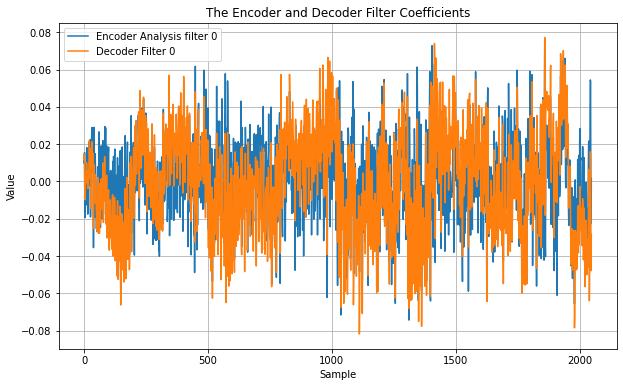

In [24]:
"""
torch.save({#'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()}, "audio_autoenc.torch")
"""
    
ww = model.state_dict()   #read obtained weights
print("ww=", ww)
#Plot obtained weights:
plt.figure(figsize=(10,6))
plt.plot(np.transpose(np.array(ww['conv1.weight'][0:1,0,:])))
plt.plot(np.transpose(np.array(ww['synconv1.weight'][0:1,0,:])))
plt.legend(('Encoder Analysis filter 0', 'Decoder Filter 0'))
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('The Encoder and Decoder Filter Coefficients')
plt.grid()

predictions.shape= (1, 1, 1976322)


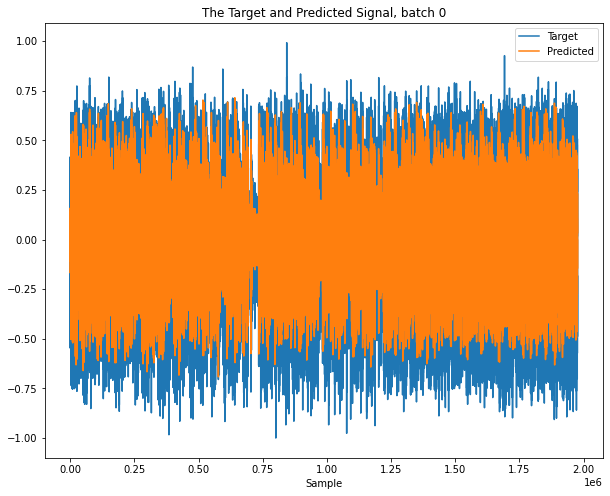

In [25]:
#Test on training set: (traning set aka using the same file that we train the model)
#This is the original input, with a synthetic noise. Our goal is to eliminate this !! se later
Xnoise=(X_train+torch.randn(X_train.size())*0.05)
#Xnoise=torch.cat((torch.zeros(1,1,100), Xnoise),dim=-1)
predictions=model(Xnoise).cpu() # Make Predictions based on the obtained weights, on training set
predictions=predictions.detach()
predictions=np.array(predictions)
Y=np.array(Y) #target
#print("Y=",Y)
print("predictions.shape=", predictions.shape)
#convert to numpy:
#https://discuss.pytorch.org/t/how-to-transform-variable-into-numpy/104/2
#Plot target signal and output of autoencoder:
plt.figure(figsize=(10,8))
for b in range(batch):
    plt.plot(np.array(Y[b,0,:]))
    plt.plot(predictions[b,0,:])
    plt.legend(('Target','Predicted'))
    plt.title('The Target and Predicted Signal, batch '+str(b))
    plt.xlabel('Sample')
    plt.show()

Xnoise=Xnoise.detach()
Xnoise=np.array(Xnoise)
xnoise=Xnoise[:,0,:]
#xnoise=np.transpose(xnoise)
#xnoise=np.clip(xnoise, -1.0,1.0)
    
xrek=predictions[:,0,:]  #remove unnecessary dimension for playback
#xrek=np.transpose(xrek)
#xrek=np.clip(xrek, -1.0,1.0)

In [26]:
import IPython.display as ipd
display(ipd.Audio(xnoise, rate=samplerate));

Output hidden; open in https://colab.research.google.com to view.

In [27]:
display(ipd.Audio(xrek, rate=samplerate));

Output hidden; open in https://colab.research.google.com to view.

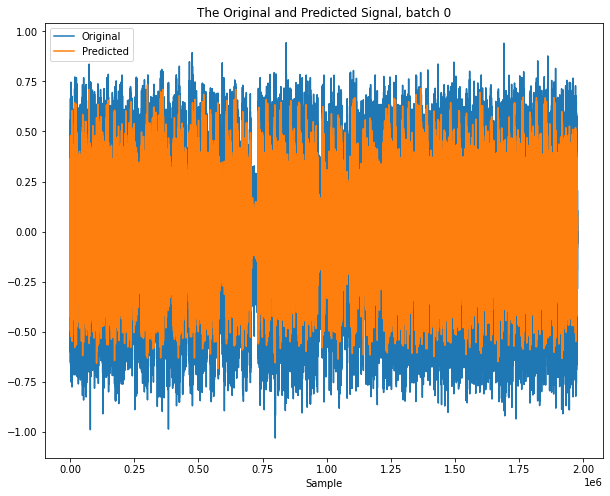

In [28]:
#Test on Verification set:
#So we test on a file that was not used (NOT SEEN, in theory) to train the model. We use the other channel, aka X_test (see above)
#we also shift ("round robin" like) and add noise, in order to stress the model, and the model is robust also on a shift sensitivity
#and obviously, to noise
X_test_shifted_100 = nn.ConstantPad1d(100, 0)(X_test)
x=X_test_shifted_100+torch.from_numpy((np.random.normal(scale=0.04, size=X_test_shifted_100.shape))).float()
predictions=model(x).cpu() # Make Predictions based on the obtained weights, on verification set
predictions=predictions.detach()
predictions=np.array(predictions)

plt.figure(figsize=(10,8))
for b in range(batch):
    plt.plot(np.array(x[b,0,:]))
    plt.plot(predictions[b,0,:])
    plt.legend(('Original','Predicted'))
    plt.title('The Original and Predicted Signal, batch '+str(b))
    plt.xlabel('Sample')
    plt.show()
xrek=predictions[:,0,:]

In [29]:
display(ipd.Audio(x[:,0,:], rate=samplerate));

Output hidden; open in https://colab.research.google.com to view.

In [30]:
display(ipd.Audio(xrek, rate=samplerate));

Output hidden; open in https://colab.research.google.com to view.

#Expriment 2 with Reduced stride=32

To obtain a better audio quality we now reduce the stride (the downsampling and upsampling factor) to 32.+
NB. it trains or optimizes much slower, because it has to process more data.
Now is less filtered, but a residual noise remains.

In [31]:
class Convautoenc(nn.Module):
    def __init__(self):
        super(Convautoenc, self).__init__()
        #Analysis Filterbank with downsampling of N=1024, filter length of 2N, but only N/2 outputs:
        self.conv1=nn.Conv1d(in_channels=1, out_channels=32, kernel_size=2048, stride=32, padding=1023, bias=True) #Padding for 'same' filters (kernel_size/2-1)

        #Synthesis filter bank:
        self.synconv1=nn.ConvTranspose1d(in_channels=32, out_channels=1, kernel_size=2048, stride=32, padding=1023, bias=True)

    def encoder(self, x):
        #Analysis:
        x = self.conv1(x)
        y = torch.tanh(x)
        return y
      
    def decoder(self, y):
        #Synthesis:
        xrek= self.synconv1(y)
        return xrek
      
    def forward(self, x):
        y=self.encoder(x)
        #y=torch.round(y/0.125)*0.125
        xrek=self.decoder(y)
        return xrek